In [74]:
import torch

In [75]:
def clean_data(data):
    clean_data = []
    valid_chars = 'âabcçefgğhıijklmnoöprsştuüvyz'
    for sample in data:
        sample = sample.lower()
        # check if all chars are valid
        if any([s not in valid_chars for s in sample]):
            continue
        clean_data.append(sample)
    return clean_data

def load_data(file_path: str): # reads csv files
    with open(file_path, 'r') as f:
        data = f.read().splitlines()
    # get only the first column
    data = [line.split(',')[0] for line in data]
    return clean_data(data)

words = clean_data(load_data('names.csv'))

In [76]:
stoi = {s: i+1 for i, s in enumerate(sorted(set(''.join(words))))}
stoi['.'] = 0 # add a special token for begin and end of word
itos = {i: s for s, i in stoi.items()}

In [77]:
data = torch.ones((len(stoi), len(stoi)), dtype = torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        data[stoi[c1], stoi[c2]] += 1

In [78]:
# probs calculation
p_sum = torch.sum(data.float(), dim=1, keepdims=True)
probs = data / p_sum

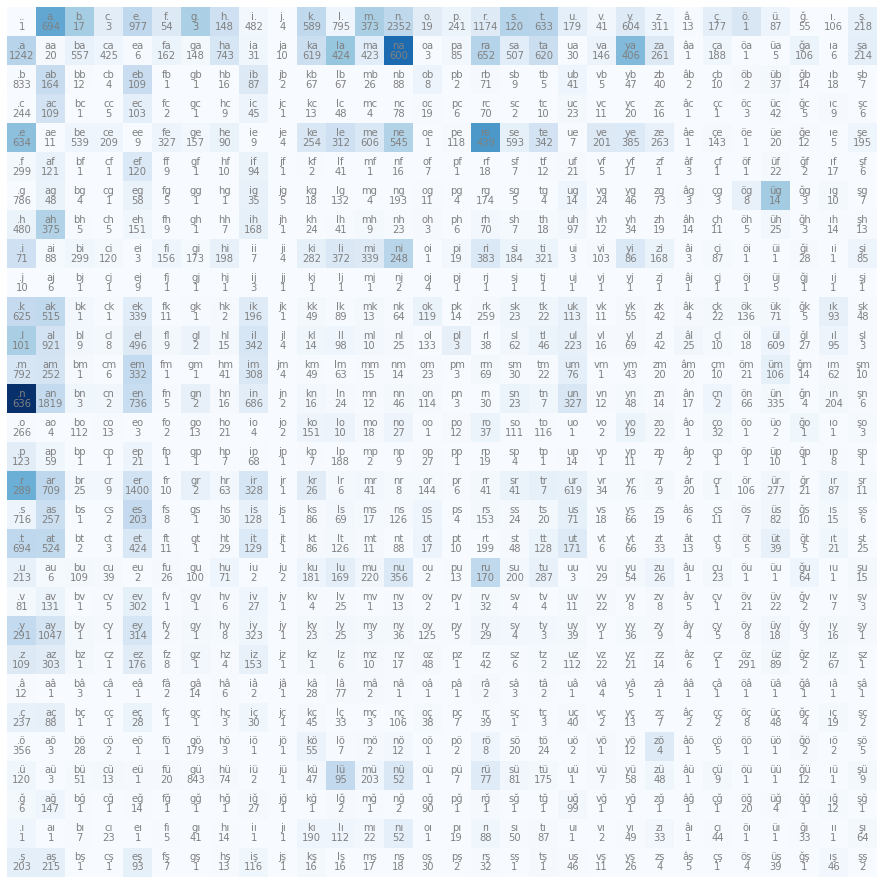

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (16, 16))
plt.imshow(data.numpy(), cmap = 'Blues')
for i in range(len(stoi)):
    for j in range(len(stoi)):
        chrstr = itos[i] + itos[j]
        plt.text(i, j, chrstr, ha = 'center', va = 'bottom', color = 'gray')
        plt.text(i, j, data[i, j].item(), ha = 'center', va = 'top', color = 'gray')
plt.axis('off')
plt.show()

In [80]:
def get_next(seed=-1):
    if seed == -1:
        seed = torch.randint(9999, (1,)).item()
    gen = torch.Generator().manual_seed(seed)
    target_idx = 0
    new_word = ''
    while True:
        target_idx = torch.multinomial(probs[target_idx], 1, 
            replacement=True, generator=gen).item()
        if target_idx == 0:
            break
        new_word += itos[target_idx]

    return new_word

for i in range(10):
    print(get_next())

sayaysebelbali
enanuan
biguy
ge
karaytivl
tan
ben
şik
güşe
gışurülirkal


## Evaluation

In [81]:
neg_ll = 0.0
ct = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        prob = probs[stoi[c1], stoi[c2]]
        logprob = torch.log(prob).item()
        neg_ll -= logprob
        ct += 1
        # print(f'{c1}{c2}: {prob:.4f}')
print(f"Avg negative likelihood (true val): {neg_ll / ct}")

Avg negative likelihood (true val): 2.467620538815921


## NN Setup for Bigram

Summary:

- Setup training dataset of xs and ys
- Setup neuron weights (n x n) - n being the number of unique characters
- Train
  - Convert the inputs to one hot vectors
  - Input ohv to the network weights to get logits
  - Convert logits to probabilities (softmax)
  - Calculate the loss
  - Set gradients to zero
  - Backpropagate the loss
  - Update the weights

In [82]:
# Creating the training set
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        xs.append(stoi[c1])
        ys.append(stoi[c2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [83]:
# Setup weights
W = torch.randn((len(stoi), len(stoi)), requires_grad=True) # initializing the weights

In [84]:
# Training
import torch.nn.functional as F

num_epochs = 200
num_unq_xs = xs.nelement()
for e in range(num_epochs):
    # Forward pass
    xenc = F.one_hot(xs, len(stoi)).float()
    logits = xenc @ W # dot product of weights and xs
    counts = torch.exp(logits)
    probs = counts / counts.sum(dim=1, keepdims=True)
    # Get loss
    loss = -probs[torch.arange(num_unq_xs), ys].log().mean()
    loss += 0.01 * (W**2).mean() # regularization
    print(f"Loss for epoch {e}: {loss}")

    # Reset gradients
    W.grad = None
    loss.backward()

    # Update
    W.data -= 50 * W.grad


Loss for epoch 0: 3.732203722000122
Loss for epoch 1: 3.4369564056396484
Loss for epoch 2: 3.250448703765869
Loss for epoch 3: 3.116868734359741
Loss for epoch 4: 3.0182044506073
Loss for epoch 5: 2.942331075668335
Loss for epoch 6: 2.882312297821045
Loss for epoch 7: 2.8341097831726074
Loss for epoch 8: 2.7949378490448
Loss for epoch 9: 2.762749433517456
Loss for epoch 10: 2.7360217571258545
Loss for epoch 11: 2.713604211807251
Loss for epoch 12: 2.6946098804473877
Loss for epoch 13: 2.6783483028411865
Loss for epoch 14: 2.6642861366271973
Loss for epoch 15: 2.652012586593628
Loss for epoch 16: 2.6412134170532227
Loss for epoch 17: 2.6316425800323486
Loss for epoch 18: 2.6231043338775635
Loss for epoch 19: 2.615440607070923
Loss for epoch 20: 2.6085238456726074
Loss for epoch 21: 2.602248430252075
Loss for epoch 22: 2.596527099609375
Loss for epoch 23: 2.5912885665893555
Loss for epoch 24: 2.5864739418029785
Loss for epoch 25: 2.582034111022949
Loss for epoch 26: 2.5779271125793457
Lo

In [85]:
def get_next_nn(seed=-1):
    if seed == -1:
        seed = torch.randint(9999, (1,)).item()
    gen = torch.Generator().manual_seed(seed)
    target_idx = 0
    new_word = []
    while True:
        xenc = F.one_hot(torch.tensor([target_idx]), num_classes=len(stoi)).float()
        logits = xenc @ W
        counts = torch.exp(logits)
        probs = counts / counts.sum(dim=1, keepdim=True)
        target_idx = torch.multinomial(probs, 1, 
            replacement=True, generator=gen).item()
        if target_idx == 0:
            break
        new_word += itos[target_idx]
    return ''.join(new_word)

In [88]:
# testing nn and normal model
for i in range(5):
    print(f"Run {i}/nn: {get_next_nn(i)}")
    print(f"Run {i}/simple bigram: {get_next(i)}")

Run 0/nn: üreyhokan
Run 0/simple bigram: ükkçiialnlnhmekkhkoiar
Run 1/nn: akahe
Run 1/simple bigram: akebeansmemesgafr
Run 2/nn: ç
Run 2/simple bigram: çasmuebaskarettmuatesrkr
Run 3/nn: alp
Run 3/simple bigram: althtr
Run 4/nn: kp
Run 4/simple bigram: ksazönntcnhya
